In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt

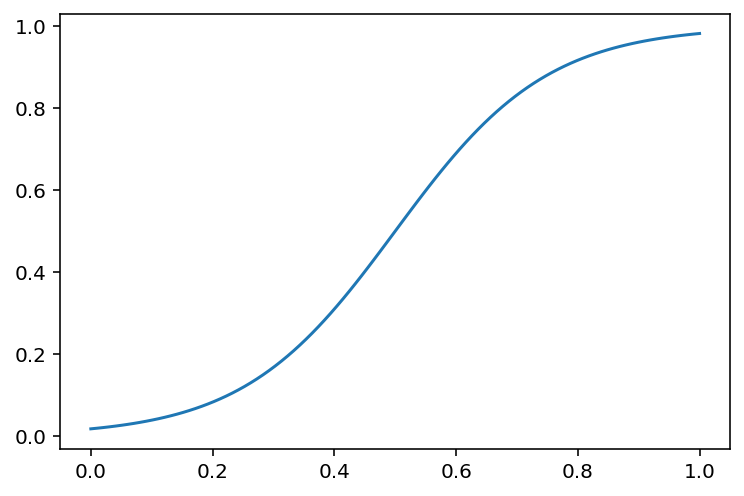

In [23]:
x = np.linspace(0.0, 1.0, 100)
y = 1 / (1+ np.exp(-8*(- 0.5 + x)))
plt.plot(x, y);

In [24]:
b = torch.tensor([0.3, 0.5, 0.2]) 
x = torch.tensor([0.3, 0.3, 0.7])
n_target = len(x)

In [25]:
"""
Monte-Carlo estimatate of the (reverse) Kullback-Leibler divergence.
"""
scale_q = 0.05
n_sample = 100
q_dist = torch.distributions.HalfNormal(scale_q)
q_samples = q_dist.sample((100,))
log_q = q_dist.log_prob(q_samples)

scale_target = 0.01
dist_target = [torch.distributions.Normal(x[t], scale_target) for t in range(n_target)]
log_p = torch.zeros((n_target, n_sample))
for t in range(n_target):
    log_p[t] = dist_target[t].log_prob(q_samples) * b[t]
log_p = log_p.sum(axis=0)

torch.mean(log_q - log_p)

tensor(707.4807)

In [10]:
scale = 0.05
target_dist = torch.distributions.HalfNormal(scale)

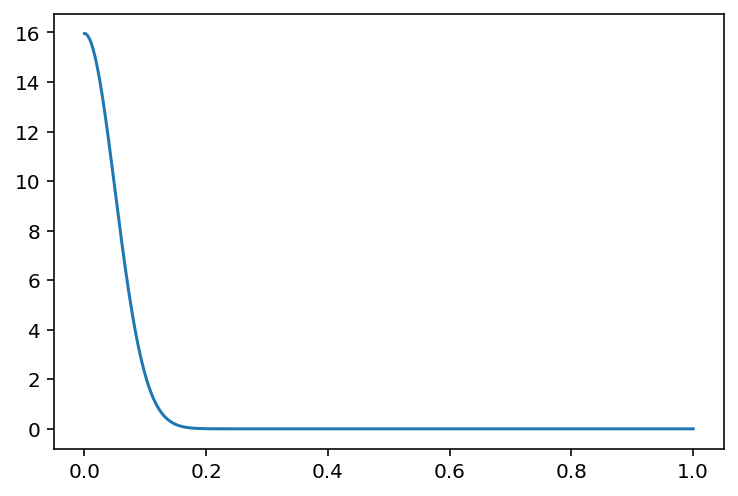

In [11]:
plt.plot(x, target_dist);

In [16]:
torch.distributions.HalfNormal(scale).sample((100, ))

tensor([5.8621e-02, 5.2384e-02, 8.3964e-03, 6.7168e-02, 6.6624e-02, 4.2854e-02,
        5.1411e-02, 8.3802e-03, 2.4924e-02, 4.7991e-02, 2.9033e-02, 2.1521e-02,
        8.6748e-02, 8.4152e-02, 1.1599e-01, 9.1445e-02, 7.9449e-02, 6.5358e-02,
        6.9699e-02, 7.5857e-05, 6.9091e-02, 3.7325e-02, 6.4969e-02, 8.7595e-03,
        6.1894e-02, 4.9368e-02, 5.1208e-02, 3.2248e-02, 4.3050e-03, 1.3295e-02,
        3.0276e-02, 9.7459e-02, 3.4941e-02, 1.1829e-01, 3.2519e-02, 2.2308e-02,
        5.0417e-03, 3.9838e-03, 2.4066e-03, 4.0439e-02, 7.4975e-02, 2.8597e-02,
        5.1064e-02, 3.4456e-02, 5.4395e-02, 3.7514e-02, 7.8448e-03, 3.0918e-02,
        4.0417e-02, 4.1336e-02, 5.2355e-02, 2.6585e-02, 5.3380e-02, 4.9901e-02,
        3.6718e-02, 3.9014e-02, 3.6818e-02, 1.5946e-02, 3.0068e-02, 9.7006e-03,
        7.1335e-02, 1.0246e-01, 5.2469e-03, 1.6243e-02, 1.6958e-02, 4.7853e-02,
        2.3440e-02, 2.6107e-03, 3.2996e-02, 2.2936e-02, 4.3973e-02, 3.0713e-02,
        2.2179e-02, 3.6048e-03, 4.7371e-

In [6]:
torch.log(torch.sigmoid(torch.tensor([2.])))

tensor([-0.1269])

In [8]:
torch.nn.functional.logsigmoid(torch.tensor([2.]))

tensor([-0.1269])

In [9]:
torch.logit(torch.sigmoid(torch.tensor([2.])))

tensor([2.0000])

In [42]:
def free_energy_belief(b_prime, b, y, x):
    
    prm = (8.0, 0.5)
    p = torch.sigmoid(prm[0]*(- prm[1] + x))
    
    p_y = p**y * (1-p)**(1-y)

    q_prime = torch.softmax(b_prime - b_prime.max(), dim=0)
    
    p_y_under_q = (p_y*q_prime).sum()
    log_p_y_under_q = p_y_under_q.log()

    log_q = torch.log_softmax(b - b.max(), dim=0)

    kl_div_q_p = torch.sum(q_prime * (q_prime.log() - log_q))
    fe = - log_p_y_under_q + kl_div_q_p
    return fe

learning_rate = 0.1
max_epochs = 1000
b = torch.ones(2)
x = torch.tensor([0.3, 0.5])
y = torch.tensor(1)

b_prime = torch.nn.Parameter(b.clone())

b.requires_grad = True

opt = torch.optim.Adam([b_prime, ], lr=learning_rate)

# Minimise free energy
for step in range(max_epochs):

    old_b_prime = b_prime.clone()

    opt.zero_grad()
    loss = free_energy_belief(b_prime=b_prime, y=y, x=x, b=b)
    loss.backward()
    opt.step()
    
    if torch.isclose(old_b_prime, b_prime).all():
        print(f"converged at step {step}")
        break

print(b_prime)

converged at step 139
Parameter containing:
tensor([0.5845, 1.4155], requires_grad=True)


In [24]:
prm = (8.0, 0.5)
x = torch.rand(4)
b = torch.rand(4)
b_prime = torch.rand(4)
y = torch.randint(high=2, size=(1, ))

q_prime = torch.softmax(b_prime - b_prime.max(), dim=0)
q = torch.softmax(b - b.max(), dim=0)

p = torch.sigmoid(prm[0]*(- prm[1] + x))
p_y = p**y * (1-p)**(1-y)

def free_energy_belief():

    p_yz = p_y * q

    return torch.sum(q_prime * (q_prime.log() - p_yz.log()))


def free_energy_belief_v2():
    
    logp_y_under_q_prime = (p_y.log()*q_prime).sum()

    kl_div_q_p = torch.sum(q_prime * (q_prime.log() - q.log()))
    fe = - logp_y_under_q_prime + kl_div_q_p
    return fe

In [25]:
%timeit free_energy_belief()

5.69 µs ± 13.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [26]:
%timeit free_energy_belief_v2()

9.55 µs ± 22.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
